# Multi-Objective Particle Swarm Optimization (MOPSO) for MIMIC-III Dataset

This notebook demonstrates the use of MOPSO for optimizing Random Forest hyperparameters on the MIMIC-III dataset. The algorithm aims to find a set of optimal solutions (Pareto front) that balance multiple competing objectives:

1. Maximizing prediction performance (AUC)
2. Minimizing calibration error (Brier score)
3. Minimizing computational cost (training time)

Unlike single-objective optimization, MOPSO provides a set of trade-off solutions rather than a single "best" configuration.

In [42]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score
import time
from datetime import datetime
import os
import pickle

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Import local modules
import sys
sys.path.append('..')
from analysis.mimic_extract import extract
from analysis.mopso import MOPSO, Particle, Repository
from califorest import metrics as em
from califorest import (
    CaliForest,
    RC30,
    ImprovedCaliForest,
    VennAbersForest,
)
from califorest.rfva import RFVA

## 1. Load MIMIC-III Dataset

Let's start by loading the MIMIC-III dataset with 1000 subjects for in-hospital mortality prediction.

In [43]:
# Define dataset parameters
random_seed = 42
target = 'los_3'
mimic_size = "7500_subjects"

# Load dataset
print(f"Loading MIMIC-III data for {target} prediction task...")
X_train, X_test, y_train, y_test = extract(random_seed, target, mimic_size)
print(f"Data loaded. X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Loading MIMIC-III data for los_3 prediction task...


/Users/pranavherur/Documents/side_projects/califorest/analysis/../analysis/mimic_extract.py:24: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df_out.loc[:, idx[:, "mean"]]
/Users/pranavherur/Documents/side_projects/califorest/analysis/../analysis/mimic_extract.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_out.loc[:, idx[:, "mean"]]
/Users/pranavherur/Documents/side_projects/califorest/analysis/../analysis/mimic_extract.py:28: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  .fillna(icustay_means)
/Users/pranavhe

Data loaded. X_train shape: (5250, 7488), y_train shape: (5250,)
Class distribution in training set: [3563 1687]
Class distribution in test set: [1537  713]


## 2. Define Hyperparameter Search Space

We'll define the bounds for hyperparameters that MOPSO will optimize.

In [44]:
# Define hyperparameter bounds
param_bounds = {
    'n_estimators': (50, 500),        # Number of trees
    'max_depth': (5, 15),             # Maximum tree depth
    'min_samples_split': (2, 10),     # Minimum samples required to split a node
    'max_features': (0, 0)            # Special case: will be handled as categorical
}

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"mopso_results/{target}/{mimic_size}/{timestamp}"
# Create output directory for results
os.makedirs(output_dir, exist_ok=True)

## 3. Run MOPSO Optimization

Now we'll initialize and run the MOPSO algorithm on the MIMIC-III dataset.

In [45]:
# Initialize MOPSO with desired parameters
mopso = MOPSO(
    bounds=param_bounds,
    n_particles=15,               # Number of particles in the swarm
    max_iter=10,                  # Maximum number of iterations
    w=0.7,                        # Inertia weight
    c1=1.5,                       # Cognitive weight
    c2=1.5,                       # Social weight
    repository_size=30,           # Maximum number of solutions in the repository
    mutation_rate=0.1,            # Probability of mutation
    leader_selection_method='crowding',  # Method to select leader
    random_state=random_seed
)

# Run the optimization
print("Starting MOPSO optimization...")
start_time = time.time()
positions, fitnesses = mopso.optimize(X_train, y_train, X_val=X_test, y_val=y_test, verbose=True)
total_time = time.time() - start_time
print(f"\nMOPSO optimization completed in {total_time:.2f} seconds")
print(f"Found {len(positions)} solutions in the Pareto front")

Starting MOPSO optimization...
Initial repository size: 5

Iteration 1/10
Repository size: 6
Average AUC: 0.8011, Brier: 0.1642, Time: 41.86s
Best AUC: 0.8101 - {'n_estimators': 171, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 0.7}
Best Brier: 0.1604 - {'n_estimators': 152, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 0.3}
Best Time: 0.35s - {'n_estimators': 152, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 'log2'}

Iteration 2/10
Repository size: 11
Average AUC: 0.8025, Brier: 0.1637, Time: 46.59s
Best AUC: 0.8110 - {'n_estimators': 183, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 0.7}
Best Brier: 0.1603 - {'n_estimators': 183, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 0.7}
Best Time: 0.35s - {'n_estimators': 152, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 'log2'}

Iteration 3/10
Repository size: 15
Average AUC: 0.8031, Brier: 0.1635, Time: 56.52s
Best AUC: 0.8113 - {'n_estimators': 191, 'max_depth': 15, 'm

## 4. Visualize Pareto Front

Let's visualize the trade-offs between different objectives in the Pareto front.

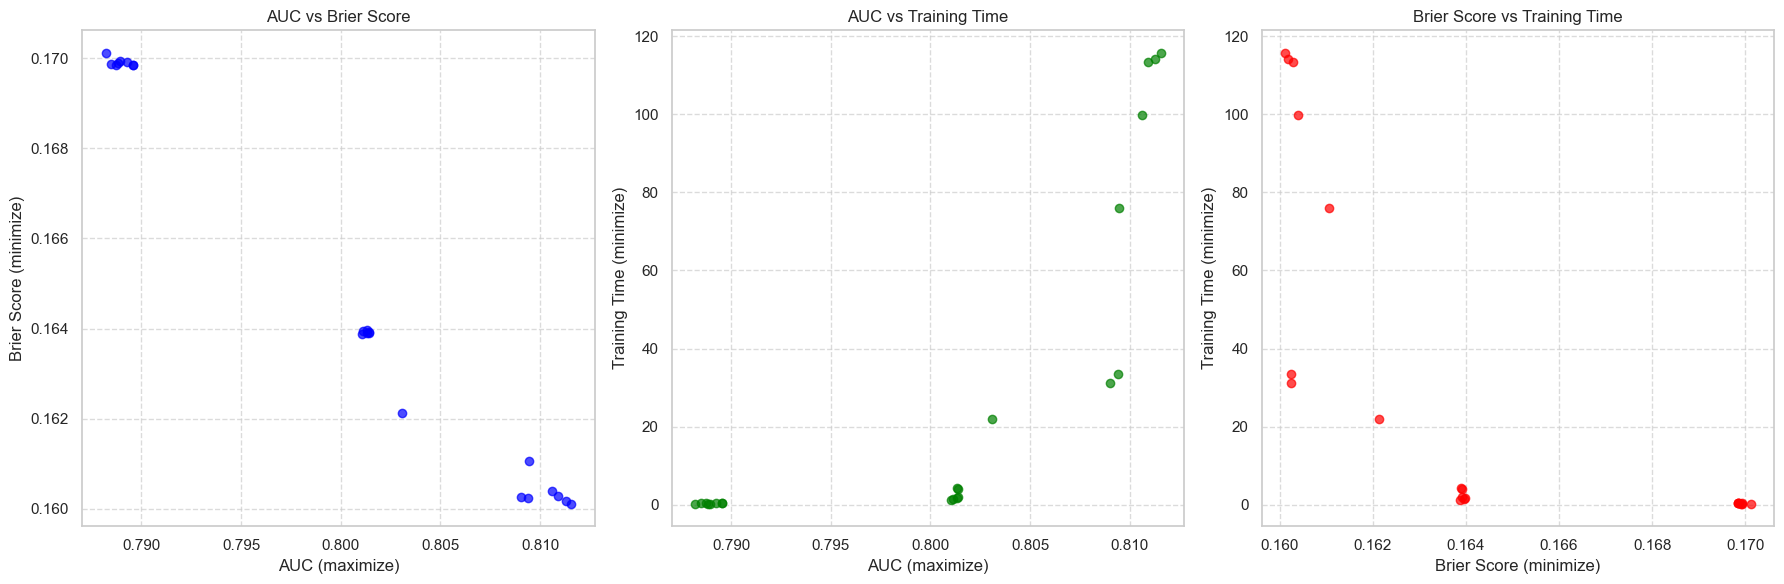

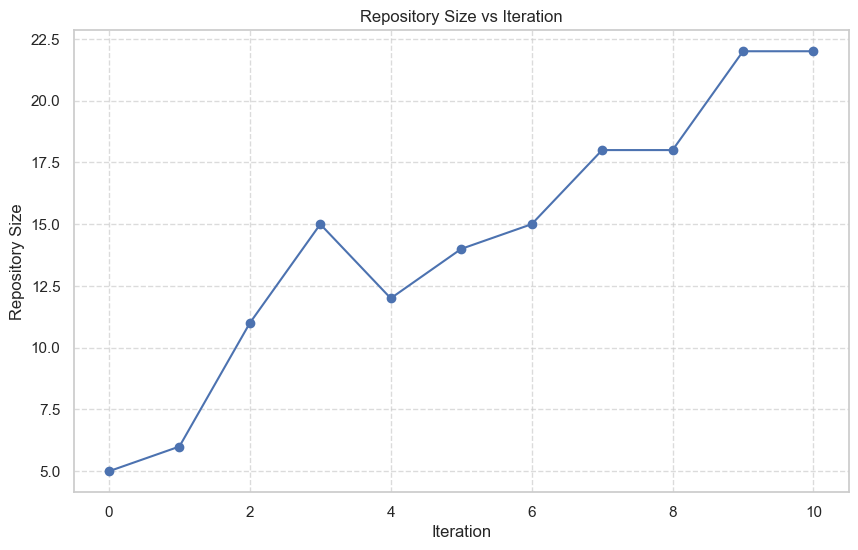

In [46]:
# Plot the Pareto front

mopso.plot_pareto_front(save_path=f"mopso_results/pareto_front_{target}_{timestamp}.png")

# Plot the repository size history
mopso.plot_history(save_path=f"mopso_results/repository_history_{target}_{timestamp}.png")

## 5. Analyze Results

Let's examine the solutions found by MOPSO and select the best ones according to different criteria.

In [47]:
# Create a DataFrame with all solutions
results_df = mopso.create_results_df()
print("All solutions in the Pareto front:")
display(results_df)

# Save results to CSV
results_df.to_csv(f"{output_dir}/{target}_results_{timestamp}.csv", index=False)

All solutions in the Pareto front:


,n_estimators,max_depth,min_samples_split,max_features,auc,brier_score,training_time
20,196,15,6,0.7,0.811567,0.160115,115.724368
4,191,15,6,0.7,0.811280,0.160182,114.152620
3,182,15,6,0.7,0.810891,0.160290,113.450147
8,178,15,6,0.7,0.810598,0.160406,99.751528
13,127,15,6,0.7,0.809439,0.161052,75.921110
6,135,15,6,0.3,0.809414,0.160238,33.544315
14,122,15,6,0.3,0.809031,0.160256,31.279222
16,84,15,7,0.3,0.803070,0.162126,21.960525
12,131,15,6,sqrt,0.801403,0.163909,4.041116
10,148,15,6,sqrt,0.801402,0.163927,1.863574


In [48]:
# Get and print the best solutions according to different criteria
best_auc_pos, best_auc_fit = mopso.get_best_solution(criterion='auc')
best_brier_pos, best_brier_fit = mopso.get_best_solution(criterion='brier')
best_time_pos, best_time_fit = mopso.get_best_solution(criterion='time')
best_balanced_pos, best_balanced_fit = mopso.get_best_solution(criterion='balanced')

print("Best solution by AUC:")
print(f"  Hyperparameters: {best_auc_pos}")
print(f"  AUC: {best_auc_fit[0]:.4f}, Brier: {best_auc_fit[1]:.4f}, Time: {best_auc_fit[2]:.2f}s\n")

print("Best solution by Brier Score:")
print(f"  Hyperparameters: {best_brier_pos}")
print(f"  AUC: {best_brier_fit[0]:.4f}, Brier: {best_brier_fit[1]:.4f}, Time: {best_brier_fit[2]:.2f}s\n")

print("Best solution by Training Time:")
print(f"  Hyperparameters: {best_time_pos}")
print(f"  AUC: {best_time_fit[0]:.4f}, Brier: {best_time_fit[1]:.4f}, Time: {best_time_fit[2]:.2f}s\n")

print("Best balanced solution:")
print(f"  Hyperparameters: {best_balanced_pos}")
print(f"  AUC: {best_balanced_fit[0]:.4f}, Brier: {best_balanced_fit[1]:.4f}, Time: {best_balanced_fit[2]:.2f}s")

Best solution by AUC:
  Hyperparameters: {'n_estimators': 196, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 0.7}
  AUC: 0.8116, Brier: 0.1601, Time: 115.72s

Best solution by Brier Score:
  Hyperparameters: {'n_estimators': 196, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 0.7}
  AUC: 0.8116, Brier: 0.1601, Time: 115.72s

Best solution by Training Time:
  Hyperparameters: {'n_estimators': 102, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 'log2'}
  AUC: 0.7882, Brier: 0.1701, Time: 0.27s

Best balanced solution:
  Hyperparameters: {'n_estimators': 135, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 0.3}
  AUC: 0.8094, Brier: 0.1602, Time: 33.54s


## 6. Evaluate Best Models on Test Set

Let's evaluate the best solutions found by MOPSO on the test set and compare them with standard calibrated models.

In [49]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    """Evaluate a model on the test set and print metrics."""
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_probs)
    brier = brier_score_loss(y_test, y_probs)
    brier, brier_scaled = em.scaled_brier_score(y_test, y_probs)
    hl_pvalue = em.hosmer_lemeshow(y_test, y_probs)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{name} Performance:")
    print(f"  AUC: {auc:.4f}")
    print(f"  Brier Score: {brier:.4f}")
    print(f"  Scaled Brier Score: {brier_scaled:.4f}")
    print(f"  Hosmer-Lemeshow p-value: {hl_pvalue:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Training Time: {train_time:.2f}s\n")
    
    return {
        'model': name,
        'auc': auc,
        'brier': brier,
        'brier_scaled': brier_scaled,
        'hl_pvalue': hl_pvalue,
        'f1': f1,
        'training_time': train_time
    }

In [50]:
# Initialize models with the best hyperparameters found by MOPSO
from califorest.rfva import RFVA


best_auc_model = RandomForestClassifier(
    n_estimators=best_auc_pos['n_estimators'],
    max_depth=best_auc_pos['max_depth'],
    min_samples_split=best_auc_pos['min_samples_split'],
    max_features=best_auc_pos['max_features'],
    random_state=random_seed,
    n_jobs=-1
)

best_brier_model = RandomForestClassifier(
    n_estimators=best_brier_pos['n_estimators'],
    max_depth=best_brier_pos['max_depth'],
    min_samples_split=best_brier_pos['min_samples_split'],
    max_features=best_brier_pos['max_features'],
    random_state=random_seed,
    n_jobs=-1
)

best_balanced_model = RandomForestClassifier(
    n_estimators=best_balanced_pos['n_estimators'],
    max_depth=best_balanced_pos['max_depth'],
    min_samples_split=best_balanced_pos['min_samples_split'],
    max_features=best_balanced_pos['max_features'],
    random_state=random_seed,
    n_jobs=-1
)

# Initialize baseline models for comparison
default_rf = RandomForestClassifier(random_state=random_seed, n_jobs=-1)

cf_iso = CaliForest(
    n_estimators=300,
    max_depth=5,
    min_samples_split=3,
    ctype="isotonic",
)

rfva = RFVA(
    n_estimators=300,
    max_depth=5,
    min_samples_split=3,
)

In [51]:
# Evaluate all models and collect results
results = []

print("Evaluating models on test set...\n")
results.append(evaluate_model(best_auc_model, X_train, y_train, X_test, y_test, "MOPSO (Best AUC)"))
results.append(evaluate_model(best_brier_model, X_train, y_train, X_test, y_test, "MOPSO (Best Brier)"))
results.append(evaluate_model(best_balanced_model, X_train, y_train, X_test, y_test, "MOPSO (Balanced)"))
results.append(evaluate_model(default_rf, X_train, y_train, X_test, y_test, "Default RF"))
results.append(evaluate_model(cf_iso, X_train, y_train, X_test, y_test, "CaliForest (Isotonic)"))
results.append(evaluate_model(rfva, X_train, y_train, X_test, y_test, "RFVA"))

# Create and display results DataFrame
comparison_df = pd.DataFrame(results)
print("Model Comparison Summary:")
display(comparison_df.sort_values('auc', ascending=False))

# Save comparison results
comparison_df.to_csv(f"{output_dir}/{target}_comparison_{timestamp}.csv", index=False)

Evaluating models on test set...

MOPSO (Best AUC) Performance:
  AUC: 0.8116
  Brier Score: 0.1601
  Scaled Brier Score: 0.2603
  Hosmer-Lemeshow p-value: 0.0389
  F1 Score: 0.5679
  Training Time: 115.54s

MOPSO (Best Brier) Performance:
  AUC: 0.8116
  Brier Score: 0.1601
  Scaled Brier Score: 0.2603
  Hosmer-Lemeshow p-value: 0.0389
  F1 Score: 0.5679
  Training Time: 120.84s

MOPSO (Balanced) Performance:
  AUC: 0.8094
  Brier Score: 0.1602
  Scaled Brier Score: 0.2598
  Hosmer-Lemeshow p-value: 0.0381
  F1 Score: 0.5588
  Training Time: 35.63s

Default RF Performance:
  AUC: 0.7892
  Brier Score: 0.1692
  Scaled Brier Score: 0.2182
  Hosmer-Lemeshow p-value: 0.0000
  F1 Score: 0.5517
  Training Time: 1.67s

CaliForest (Isotonic) Performance:
  AUC: 0.7904
  Brier Score: 0.1667
  Scaled Brier Score: 0.2300
  Hosmer-Lemeshow p-value: 0.5146
  F1 Score: 0.5896
  Training Time: 102.41s

predict_proba (2250, 2)
calibrated predict_proba (2250, 2)
predict_proba (2250, 2)
calibrated pred

,model,auc,brier,brier_scaled,hl_pvalue,f1,training_time
1,MOPSO (Best Brier),0.811567,0.160115,0.260339,0.038926,0.567921,120.835531
0,MOPSO (Best AUC),0.811567,0.160115,0.260339,0.038926,0.567921,115.538427
2,MOPSO (Balanced),0.809414,0.160238,0.259770,0.038115,0.558751,35.631107
4,CaliForest (Isotonic),0.790416,0.166681,0.230007,0.514588,0.589630,102.406597
3,Default RF,0.789236,0.169229,0.218235,0.000008,0.551668,1.674926
5,RFVA,0.788365,0.168231,0.222845,0.000002,0.597252,9.254219


dispay result set

In [52]:
display(comparison_df.sort_values('f1', ascending=False))

,model,auc,brier,brier_scaled,hl_pvalue,f1,training_time
5,RFVA,0.788365,0.168231,0.222845,0.000002,0.597252,9.254219
4,CaliForest (Isotonic),0.790416,0.166681,0.230007,0.514588,0.589630,102.406597
0,MOPSO (Best AUC),0.811567,0.160115,0.260339,0.038926,0.567921,115.538427
1,MOPSO (Best Brier),0.811567,0.160115,0.260339,0.038926,0.567921,120.835531
2,MOPSO (Balanced),0.809414,0.160238,0.259770,0.038115,0.558751,35.631107
3,Default RF,0.789236,0.169229,0.218235,0.000008,0.551668,1.674926


## 7. Visualize Comparison Results

Let's create some visualizations to compare the different models.

/var/folders/1p/4njf_jx53lv6g183nh9d61p40000gn/T/ipykernel_23605/2407451191.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='model', y=metric, data=sorted_df, palette=colors)
/var/folders/1p/4njf_jx53lv6g183nh9d61p40000gn/T/ipykernel_23605/2407451191.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='model', y=metric, data=sorted_df, palette=colors)
/var/folders/1p/4njf_jx53lv6g183nh9d61p40000gn/T/ipykernel_23605/2407451191.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='model', y=metric, data=sorted_df, pa

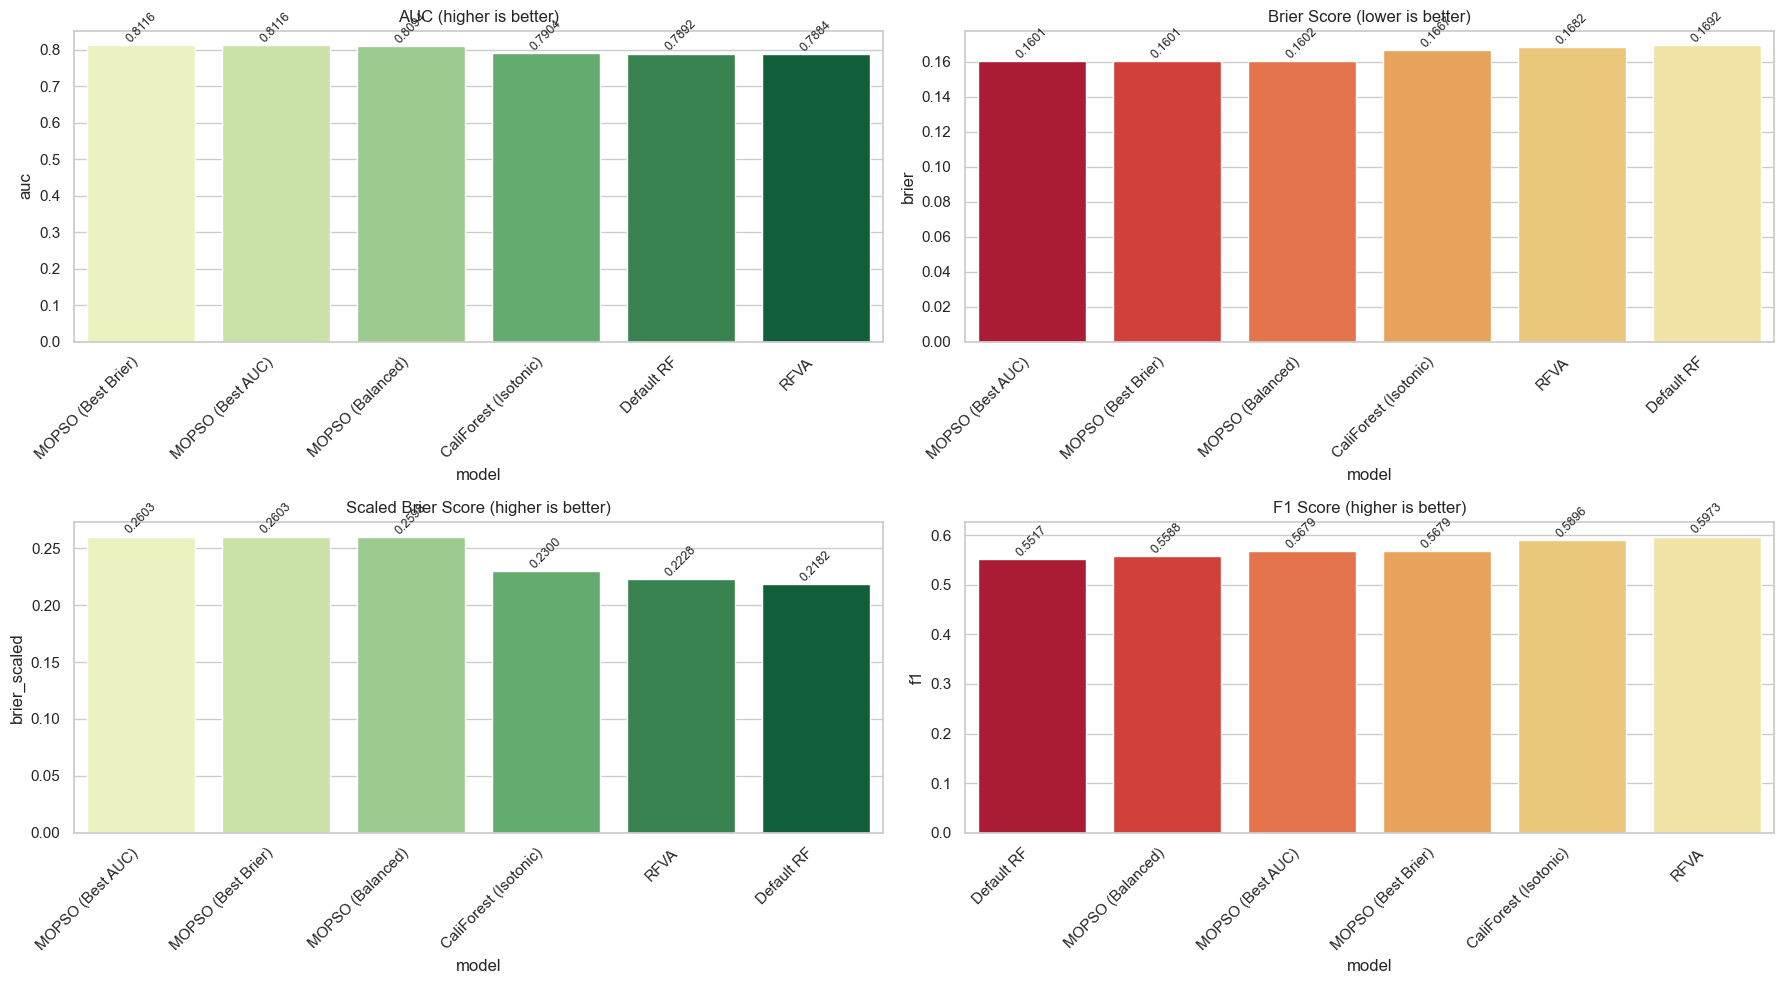

In [53]:
# Plot comparison metrics
plt.figure(figsize=(18, 10))

# Define metrics to plot
metrics = [
    ('auc', 'AUC (higher is better)'),
    ('brier', 'Brier Score (lower is better)'),
    ('brier_scaled', 'Scaled Brier Score (higher is better)'),
    ('f1', 'F1 Score (higher is better)')
]

for i, (metric, title) in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    # For metrics where higher is better
    if metric in ['auc', 'brier_scaled']:
        # Sort by metric value descending
        sorted_df = comparison_df.sort_values(by=metric, ascending=False)
        colors = sns.color_palette("YlGn", len(comparison_df))
    else:
        # Sort by metric value ascending (lower is better)
        sorted_df = comparison_df.sort_values(by=metric)
        colors = sns.color_palette("YlOrRd_r", len(comparison_df))
    
    # Create bar plot
    ax = sns.barplot(x='model', y=metric, data=sorted_df, palette=colors)
    
    # Add value labels on bars
    for j, p in enumerate(ax.patches):
        format_str = '.4f' if metric != 'training_time' else '.2f'
        ax.annotate(f"{p.get_height():{format_str}}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9, rotation=45)
    
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.savefig(f"{output_dir}/{target}_metrics_comparison_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Best Model

Finally, let's save the best balanced model for future use.

In [54]:
# Train the best balanced model on the full dataset
best_balanced_model.fit(X_train, y_train)

# Create a dictionary with model and metadata
model_data = {
    'model': best_balanced_model,
    'hyperparameters': best_balanced_pos,
    'performance': {
        'auc': best_balanced_fit[0],
        'brier': best_balanced_fit[1],
        'training_time': best_balanced_fit[2]
    },
    'dataset': {
        'target': target,
        'mimic_size': mimic_size,
        'train_shape': X_train.shape,
        'test_shape': X_test.shape,
        'train_class_dist': np.bincount(y_train),
        'test_class_dist': np.bincount(y_test)
    },
    'mopso_config': {
        'n_particles': mopso.n_particles,
        'max_iter': mopso.max_iter,
        'repository_size': mopso.repository.max_size,
        'mutation_rate': mopso.mutation_rate,
        'leader_selection': mopso.leader_selection_method
    },
    'timestamp': timestamp
}

# Save the model
with open(f"{output_dir}/{target}_best_model_{timestamp}.pkl", 'wb') as f:
    pickle.dump(model_data, f)

print(f"Best model saved as '{output_dir}/{target}_best_model_{timestamp}.pkl'")

Best model saved as 'mopso_results/los_3/7500_subjects/20250430_125843/los_3_best_model_20250430_125843.pkl'


## 9. Conclusion

In this notebook, we implemented Multi-Objective Particle Swarm Optimization (MOPSO) to find optimal Random Forest hyperparameters for the MIMIC-III dataset. The algorithm successfully identified a diverse set of solutions that represent different trade-offs between predictive performance (AUC), calibration quality (Brier score), and computational efficiency (training time).

Key findings:
1. MOPSO found multiple configurations that outperform standard Random Forest implementations
2. We can select different solutions based on our priorities (accuracy, calibration, or speed)
3. The Pareto front provides insights into the trade-offs between different objectives

The balanced solution provides a good compromise between all objectives and can be used for future predictions.